## 1.READ AND TRANSFORM

In [2]:
from pandas import read_csv

path='./data/bd_customer.csv'
customer=read_csv(path,sep=';',decimal=',')

path='./data/bd_products.csv'
products=read_csv(path,sep=';',decimal=',')

path='./data/bd_orders.csv'
orders=read_csv(path,sep=';',decimal=',')


In [3]:
#drop nan
filter_row=orders['ID_CUSTOMER'].isna()|orders['ID_PROD'].isna()
orders=orders[~filter_row]
#transform data
columns=['ID_CUSTOMER','ID_PROD']
orders[columns]=orders[columns].astype(int)

In [4]:
#create features
from pandas import to_datetime
orders['DATE']=to_datetime(orders['DATE'],format='%Y%m%d')

orders['year']=orders['DATE'].dt.year
orders['month']=orders['DATE'].dt.month


# 2.Business Questions

1. Rank ABC products
2. Which is the best period for sales?
3. Which are the best cities to sale?


### 2.1.RANK ABC PRODUCTS

In [95]:
feature_measure='INVOICE'
abc_rank=orders.groupby(['ID_PROD'])[[feature_measure]].sum().sort_values(by=feature_measure,ascending=False).round(0).reset_index()
abc_rank['SHARE']=(abc_rank[feature_measure]/abc_rank[feature_measure].sum()).round(4)
abc_rank['cumulative_sum']=abc_rank['SHARE'].cumsum()

abc_rank.loc[:,'class']='C'
abc_rank.loc[abc_rank['cumulative_sum'].between(0,0.7),'class']='A'
abc_rank.loc[abc_rank['cumulative_sum'].between(0.7,0.95),'class']='B'

abc_rank['rank']=abc_rank.index+1

abc_rank['PRODUCT_NAME']=abc_rank['ID_PROD'].map(products.set_index('ID_PRODUCT')['product_description'])

abc_rank.head(10)

,ID_PROD,INVOICE,SHARE,cumulative_sum,class,rank,PRODUCT_NAME
0,32305104,301805389.0,0.3297,0.3297,A,1,VELTRO 05 23
1,30305016,225371659.0,0.2462,0.5759,A,2,VELTRO 05 03
2,31405060,124582355.0,0.1361,0.7120,B,3,VELTRO 05 14
3,12302100,81433786.0,0.0890,0.8010,B,4,XENORA 02 23
4,10302009,46905889.0,0.0512,0.8522,B,5,XENORA 02 03
5,10701036,31556600.0,0.0345,0.8867,B,6,XENORA 01 07
6,31405062,20151673.0,0.0220,0.9087,B,7,VELTRO 05 14
7,31203154,14833092.0,0.0162,0.9249,B,8,VELTRO 03 12
8,30103004,12795149.0,0.0140,0.9389,B,9,VELTRO 03 01
9,31205155,9459707.0,0.0103,0.9492,B,10,VELTRO 05 12


### 2.2. Best period of sales

December is the best month for sales. 
The first four months of year have a good value.
Sales are not good betweem June, July and August. 

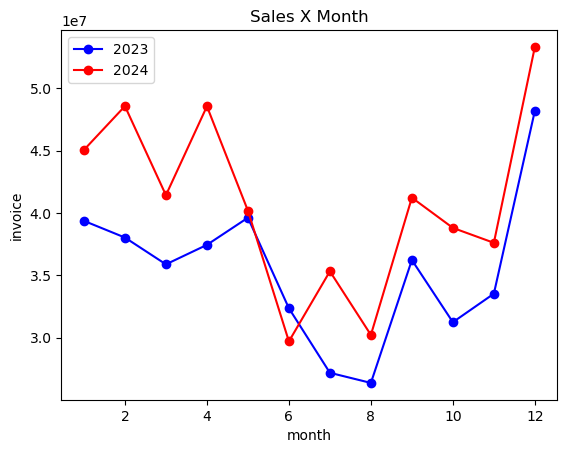

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2023,39366326.07,38028230.33,35881771.37,37443118.53,39618215.58,32360072.82,27187660.53,26375875.87,36227211.49,31243798.54,33528010.71,48189564.96
2024,45054283.17,48562236.34,41425067.39,48549381.00,40184366.82,29705078.66,35322840.88,30222297.29,41225498.31,38803591.84,37606462.84,53309735.95


In [6]:
bd_graph=orders.copy()
bd_graph['ref_mes']=bd_graph['year'].astype(str)+'-'+bd_graph['month'].astype(str)
bd_graph=bd_graph.groupby(['year','month'])[['INVOICE']].sum().reset_index()


import matplotlib.pyplot as plt

# Dados de exemplo
x = bd_graph.loc[bd_graph['year']==2023,'month']
y1 = bd_graph.loc[bd_graph['year']==2023,'INVOICE']
y2 = bd_graph.loc[bd_graph['year']==2024,'INVOICE']

# Criando o gráfico
plt.plot(x, y1, label='2023', color='blue', marker='o')
plt.plot(x, y2, label='2024', color='red', marker='o')

# Adicionando título e rótulos
plt.title('Sales X Month')
plt.xlabel('month')
plt.ylabel('invoice')

# Exibindo legenda
plt.legend()

# Mostrando o gráfico
plt.show()
display(bd_graph.pivot(index='year',columns='month',values='INVOICE'))

### 3. TOP cities

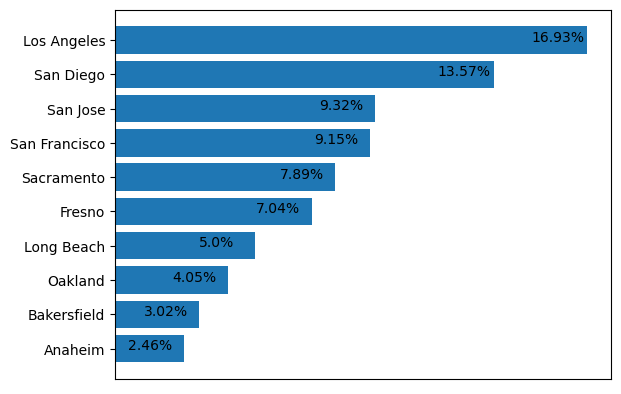

In [115]:
bd_graph=orders.copy()
bd_graph['city']=bd_graph['ID_CUSTOMER'].map(customer.set_index('ID_CUSTOMER')['CITY'])
bd_graph=bd_graph.groupby(['city'])[['INVOICE']].sum().reset_index()
bd_graph['share']=(bd_graph['INVOICE']/bd_graph['INVOICE'].sum()).round(4)

bd_graph=bd_graph.sort_values(by='INVOICE',ascending=False)
bd_graph=bd_graph.head(10).sort_values(by='INVOICE',ascending=True)
bd_graph=bd_graph.reset_index(drop=True)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

x = bd_graph['city']
y1 = bd_graph['share']
ax.barh(x, y1, align='center')
#rotulo de dado
for i, v in enumerate(bd_graph['share']):
    ax.text(x=y1[i]-0.02 , y = i-0.03,s=f'{round(v*100,2)}%')
#ocultar eixo
ax.get_xaxis().set_visible(False)

plt.show()


### 2.4. channel

In [120]:
bd_graph=orders.copy()
bd_graph['city']=bd_graph['ID_CUSTOMER'].map(customer.set_index('ID_CUSTOMER')['CHANNEL'])
bd_graph=bd_graph.groupby(['city'])[['INVOICE']].sum().reset_index()
bd_graph['share']=(bd_graph['INVOICE']/bd_graph['INVOICE'].sum()).round(4)

bd_graph

,city,INVOICE,share
0,1,4.949108e+07,0.0541
1,2,3.162111e+08,0.3454
2,3,2.874767e+08,0.3140
3,4,2.618422e+08,0.2860
4,5,7.792868e+04,0.0001
5,6,3.217607e+05,0.0004
